
# EVAL Problem 1

In this EVAL problem, we will study the behavior of a system with a
configurable FIFO vs. SJN queue dispatch (a.k.a. scheduling) policy.
The goal of this EVAL is to demonstrate that despite no changes are
made to the workload, some key system metrics might change if the system is able to meaningfully reorder the pending workload for processing.

In [146]:
# Imports
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re
from collections import defaultdict

------
a\) First thing first, let us understand the overhead of using SJN as
the queue scheduling policy. Measuring overheads is always hard, but
luckily for you when things are implemented on a real machine like
these assignments, measuring the true machine behavior becomes
possible!

We are going to measure overheads in two situations: (1) at low
utilization, and (2) at high utilization. In both cases, you will run
the commands provided below 10 times and extract the average server
runtime. We will then compare the average obtained under FIFO vs.
those obtained under SJN.

\(1\) **Low Utilization.** In the low-utilization test, run 10 times
the following command for the FIFO experiment:

`/usr/bin/time -v ./build/server_pol -w 2 -q 100 -p FIFO 2222 & ./client -a 10 -s 20 -n 1500 2222`

As you can see the `/usr/bin/time` utility is prefixed to the server to
obtain the final runtime statistics. You should parse the 10 results
from this command that are found in the “Elapsed (wall clock)
time”statistic reported by the `/usr/bin/time` utility at the end of the
run, and compute an average of these values.

Now, repeat the same thing by replacing `-p FIFO` with `-p SJN` in the
command above. Collect the new 10 values of wall-clock times and
compute the average. Finally, compare the average runtime computed for
FIFO vs. SJN.

\(2\) **High Utilization.** In the high-utilization test, we follow an
identical procedure as above, with the only difference that we change
the amount of workload sent by the client. The new command template
will be:

`/usr/bin/time -v ./build/server_pol -w 2 -q 100 -p <policy> 2222 &
./client -a 40 -s 20 -n 1500 2222`

where `<policy>` should be set to FIFO in the first 10 runs, and to
SJN in the last 10 runs.

Compare the average runtime under `FIFO` and `SJN` at low and high
utilization, reasoning on the extra per-request time spent by the
server under the two policies.

In [147]:
def extract_times_from_file(filename):
	with open(filename, 'r') as file:
			content = file.readlines()
	times = []
	for line in content:
			match = re.search(r'(\d+:\d+\.\d+)', line)
			if match:
					times.append(match.group(1))
	return times

def compute_average_time(times):
    total_seconds = 0
    for time_str in times:
        minutes, seconds = map(float, time_str.split(':'))
        total_seconds += minutes * 60 + seconds
    return total_seconds / len(times) if times else None

def process_file_and_get_average(filename):
    times = extract_times_from_file(filename)
    average_time = compute_average_time(times)
    return average_time

if __name__ == "__main__":
    fifo_low = './partA/fifo_low.txt'
    sjn_low = './partA/sjn_low.txt'
    fifo_high = './partA/fifo_high.txt'
    sjn_high = './partA/sjn_high.txt'
    
    fifo_low_avg = process_file_and_get_average(fifo_low)
    sjn_low_avg = process_file_and_get_average(sjn_low)
    fifo_high_avg = process_file_and_get_average(fifo_high)
    sjn_high_avg = process_file_and_get_average(sjn_high)
    
    print(f"Average time for FIFO low : {fifo_low_avg:.2f} seconds")
    print(f"Average time for SJN low : {sjn_low_avg:.2f} seconds")
    print(f"Average time for FIFO high : {fifo_high_avg:.2f} seconds")
    print(f"Average time for SJN high : {sjn_high_avg:.2f} seconds")


Average time for FIFO low : 150.73 seconds
Average time for SJN low : 150.72 seconds
Average time for FIFO high : 38.03 seconds
Average time for SJN high : 39.02 seconds


According to the above data, it shows that the overhead difference between FIFO and SJN is negligible. Both policies yield almost identical results bcause, under light load, the need to reorder jobs is not significant, and thus the scheduling overhead for SJN is minimal.

Under high utilization, SJN takes slightly longer than FIFO. This difference in runtime indicates that SJN introduces a small overhead when the system is highly utilized. This can be expected since SJN needs to evaluate the job queue and reorder the tasks, which can add a small computational cost when the server is busy.

-----
b\) Okay, we have understood the cost of SJN with the measurements
above. Now let us quantify the benefits. In a way similar to what we
did in `HW1`, we can measure the average response time as a function of
the server utilization. Recall that the utilization is computed as the
sum of the length of all the processed requests over the total server
runtime. With only one worker, that should be a number less than or
equal to 1, with two workers it should be less than or equal to 2, and
so on.

For this experiment, we will always set `-w 2` to spawn two workers.
Next, do a series of experiments where you run the following template
command 10 times:

`./server_pol -w 2 -q 100 -p FIFO 2222 & ./client -a \<arr_rate\> -s 20
-n 1500 2222`

Where the parameter `<arr_rate>` goes from a value of 22 (first run)
to a value of 40 (10th run), thus increasing by 2 at every run. Use
these experiments to construct a curve of the request response time as
a function of the server utilization.

Now, do 10 more runs with the same strategy as described above, but
where the server policy is set to SJN, thus the new command template
will be:

`./server_pol -w 2 -q 100 -p SJN 2222 & ./client -a <arr_rate> -s 20
-n 1500 2222`

Plot the two curves (one from the FIFO experiments, and the other from
the SJN experiments) in the same plot and try to quantify which
queueing policy works better and by how much.

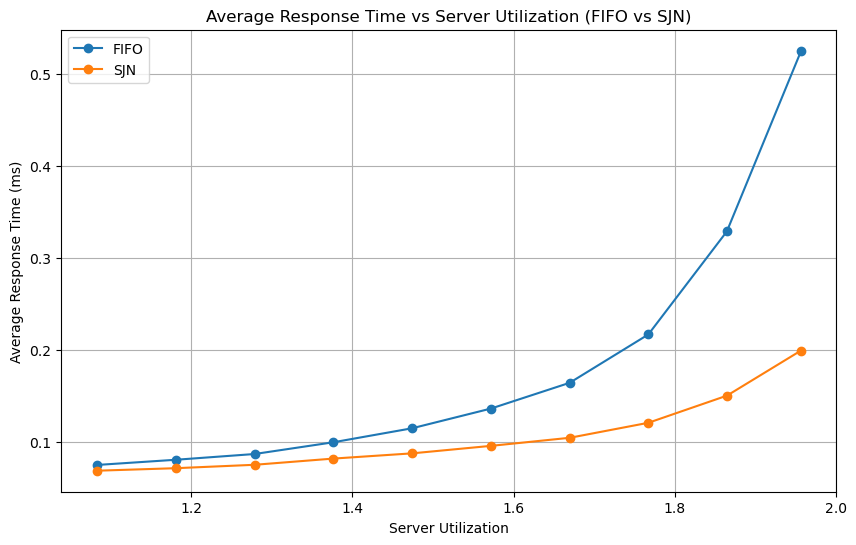

In [148]:
fifo = './partB/FIFO'
sjn = './partB/SJN'
request_pattern = r'T(\d+) R\d+:(\d+\.\d+),.*?,(\d+\.\d+),(\d+\.\d+),(\d+\.\d+)'

def calculate_utilization(file_path):
	thread_times = defaultdict(float)  
	earliest_start = float('inf')    
	latest_completion = float('-inf') 

	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(request_pattern, line)
			if match:
				thread_id = int(match.group(1))              
				start_time = float(match.group(4))          
				completion_time = float(match.group(5))      

				time_spent = completion_time - start_time
				thread_times[thread_id] += time_spent

				earliest_start = min(earliest_start, start_time)
				latest_completion = max(latest_completion, completion_time)

	total_elapsed_time = latest_completion - earliest_start

	total_utilization = sum(thread_times.values()) / total_elapsed_time

	return total_utilization 


def calculate_response_time(file_path):
	response_times = [] 
	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(request_pattern, line)
			if match:
				completion_time = float(match.group(5))  
				receipt_time = float(match.group(2))     
				response_time = completion_time - receipt_time 
				response_times.append(response_time)
	return np.mean(response_times)  


def process(directory):
	utilizations = []
	response_times = []
	files = os.listdir(directory)
	for file in files:
		if file.endswith('.txt'):
			file_path = os.path.join(directory, file)
			
			utilization = calculate_utilization(file_path)
			avg_response_time = calculate_response_time(file_path)
			
			utilizations.append(utilization)
			response_times.append(avg_response_time)

	return sorted(utilizations), sorted(response_times)


fifo_utilizations, fifo_response_times = process(fifo)
sjn_utilizations, sjn_response_times = process(sjn)

plt.figure(figsize=(10, 6))

plt.plot(fifo_utilizations, fifo_response_times, marker='o', label='FIFO')

plt.plot(sjn_utilizations, sjn_response_times, marker='o', label='SJN')

plt.xlabel('Server Utilization')
plt.ylabel('Average Response Time (ms)')
plt.title('Average Response Time vs Server Utilization (FIFO vs SJN)')
plt.legend()

plt.grid(True)
plt.show()


FIFO shows an exponential increase in response time as server utilization approaches 2. This suggests that when the server is heavily utilized, FIFO struggled to efficiently manage response times. SJN consistently maintains a lower average response time compared to FIFO across all levels of server utilization. The difference becomes more pronounced as utilization increases, indicating the efficiency of SJN in high-utilization scenarios.

SJN outperforms FIFO across the board. SJn prioritizes shorter jobs, leading to a quicker overall response times, espeically under high load. The benefit of SJN over FIFO grows significantly when server utilization goes beyond 1.5, as can be seen from the widening gap between the 2 curves.

To quantify the results at high utilization (around 2), the response time for SJN is approximately half of what it is for FIFO. This quantifies a 50% improvement in response time in favor for SJN in high-load situations.

-----
c\) In the engineering world, we say that there is no free lunch. If
one of the two policies works better than the other, where is the
catch? We are set to discover that with the following experiment. The
response time average only tells part of the story, so let us study
the full distribution of response times.

Focus on the outputs produced in the previous experiment by the 10th
run (the one where you set `-a 40`) of each policy (FIFO and SJN).
Produce TWO separate plots, each depicting the CDF of the response
times observed in the two runs under analysis. Make sure that in both
plots, the range of the *x* and *y* axis are the same, so that they
are visually comparable.

In the CDF plots, add two vertical bars: (1) one marking the value of
the average response time, and (2) another marking the 99th percentile
response time value.

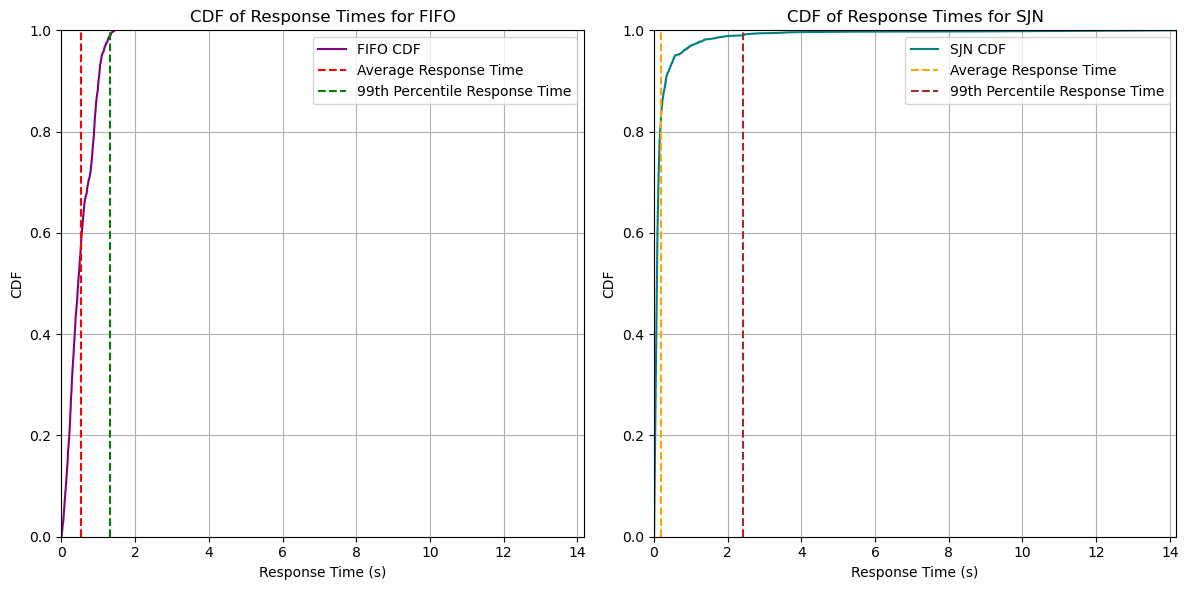

In [149]:
def calculate_response_time(file_path):
    response_times = []
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(request_pattern, line)
            if match:
                completion_time = float(match.group(5)) 
                receipt_time = float(match.group(2))    
                response_time = completion_time - receipt_time 
                response_times.append(response_time)
    return response_times

def calculate_cdf(response_times):
    sorted_times = np.sort(response_times) 
    cdf_values = np.arange(1, len(sorted_times) + 1) / len(sorted_times) 
    return sorted_times, cdf_values

fifo_file = './partB/FIFO/server_log_FIFO_a40.txt'
sjn_file = './partB/SJN/server_log_SJN_a40.txt'

fifo_response_times = calculate_response_time(fifo_file)
sjn_response_times = calculate_response_time(sjn_file)

fifo_sorted_times, fifo_cdf_values = calculate_cdf(fifo_response_times)
sjn_sorted_times, sjn_cdf_values = calculate_cdf(sjn_response_times)

fifo_avg_response_time = np.mean(fifo_response_times)
fifo_99th_percentile = np.percentile(fifo_response_times, 99)

sjn_avg_response_time = np.mean(sjn_response_times)
sjn_99th_percentile = np.percentile(sjn_response_times, 99)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fifo_sorted_times, fifo_cdf_values, label='FIFO CDF', color='purple')  # Changed to purple
plt.axvline(x=fifo_avg_response_time, color='red', linestyle='--', label='Average Response Time')
plt.axvline(x=fifo_99th_percentile, color='green', linestyle='--', label='99th Percentile Response Time')
plt.title('CDF of Response Times for FIFO')
plt.xlabel('Response Time (s)')
plt.ylabel('CDF')
plt.xlim([0, max(fifo_sorted_times.max(), sjn_sorted_times.max())])
plt.ylim([0, 1])
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sjn_sorted_times, sjn_cdf_values, label='SJN CDF', color='teal')  # Changed to teal
plt.axvline(x=sjn_avg_response_time, color='orange', linestyle='--', label='Average Response Time')  # Changed to orange
plt.axvline(x=sjn_99th_percentile, color='brown', linestyle='--', label='99th Percentile Response Time')  # Changed to brown
plt.title('CDF of Response Times for SJN')
plt.xlabel('Response Time (s)')
plt.ylabel('CDF')
plt.xlim([0, max(fifo_sorted_times.max(), sjn_sorted_times.max())])
plt.ylim([0, 1])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

-----
d\) Now focus on the differences that you see between the two CDF
plots. Reason on the spread of the response time distribution and on
the overall predictability of the system when evaluated by looking
response time metric. *HINT:* see possible definitions of
predictability in the CS350 book.

Finally, provide a motivated answer to the question: *which queuing
policy leads to a more predictable system behavior?*

For a FIFO CDF, the response times are tightly clustered near the beginning, indicating that most requests are processed quickly and consistently. A narrow spread suggests less variability in response times, contributing to predictability. The average response times close, it shows uniformity in response times. 

For the SJN CDF, it shows faster average response times but it has a wider spread due to prioritizing shorter jobs, leading to less predictability for longer jobs.

FIFO leads to a more predictable behavior, handling requests in arrival order and ordering consistent response times across different request sizes.